In [1]:
import pandas as pd #To allow us to work with dataframes
import numpy as np #To allow us to make mathematical transformations
import matplotlib.mlab as mlab #To create plots
import matplotlib.pylab as plt #To create plots
%matplotlib inline 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4 #width x height in inches
import category_encoders as ce #To encode our nominal and categorical variables
from sklearn import preprocessing, metrics #This module can be helpful when processing data
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, RandomizedSearchCV
from scipy.stats import uniform, chi2_contingency, chisquare
import pickle
#import scipy as sp #To play with scikit-learn.
import sys 
!{sys.executable} -m pip install xgboost

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#Models to import
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
#from xgboost import XGBClassifier

#updating xgboost and scipy to get rid of an error (9/18/19)
#RUN IN TERMINAL
# pip install --upgrade xgboost 
# pip install --upgrade scipy
# pip install --upgrade sklearn

#I don't believe that we need this if we export the entire sklearn library. I will comment these out 
#until it's time to start training models.
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

In [3]:
############## ONLY RUN THIS CELL ONCE ##############
#Load in the test and train data
train_house = pd.read_csv('train.csv')
test_house = pd.read_csv('test.csv')

#We will seperate the training set into features (train_X) and the predictor variable (train_y)
train_X = train_house.loc[:,train_house.columns != 'SalePrice']
train_y = train_house.SalePrice


#There are no predictions to compare with, you submit them on Kaggle.
test_X = test_house

#This is used so we can see the full output display of the iPython Notebook.
pd.options.display.max_rows = 4000
pd.set_option('display.max_columns', None)


#Removing some indices that I discovered from preliminary research along with some bad data from the columns listed above
#332 -> BsmtFinType2 is NaN while the other basement variables are okay, so I didn't know what to replace this with.
#948 -> BsmtExposure was NaN while other basement variables are okay.
#1379 -> Removed the Electrical NaN in the dataset, it is stupid to keep this.
#We can still clean up the training data and throw some rows out but we cannot do this for the
#testing data because Kaggle requires all 1459 rows to be intact. Therefore, we need to fix the 
#the NaN's in the testing set by setting them as NA instead.
train_X = train_X.drop(train_X.index[[332,948,1379]])
train_X = train_X.reset_index(drop = True)
train_y = train_y.drop(train_y.index[[332,948,1379]])
train_y = train_y.reset_index(drop = True)

train_IDs = train_X.Id #Save these so we can extract the training data from the combined_df later
test_IDs = test_X.Id #Save these so we can extract the testing datra from the combined_df later

#COMBINING THE TRAINING AND TESTING DATASETS TO CREATE A SUPER DATA SET.
combined_df = pd.concat([train_X,test_X])
combined_df = combined_df.reset_index(drop = True)


In [4]:
########This cell is solely dedicated to looking at the NaN values more closely, and replacing them with smarter values.
# Checking on the missing values in the combined dataset.
# np.sum(combined_df.isnull())

#Columns with missing data.
# MSZoning            4 X
# LotFrontage       486 X
# Alley            2718 X
# Utilities           2 X
# Exterior1st         1 X
# Exterior2nd         1 X
# MasVnrType         24 X
# MasVnrArea         23 X
# BsmtQual           81 X
# BsmtCond           82 X
# BsmtExposure       81 X
# BsmtFinType1       79 X
# BsmtFinSF1          1 X
# BsmtFinType2       79 X
# BsmtFinSF2          1 X
# BsmtUnfSF           1 X
# TotalBsmtSF         1 X
# BsmtFullBath        2 X
# BsmtHalfBath        2 X
# KitchenQual         1 X
# Functional          2 X
# FireplaceQu      1419 X
# GarageType        157 X
# GarageYrBlt       159 X
# GarageFinish      159 X
# GarageCars          1 X
# GarageArea          1 X
# GarageQual        159 X
# GarageCond        159 X
# PoolQC           2906 X
# Fence            2345 X
# MiscFeature      2811 X
# SaleType            1 X

#Only for numerical variables.
corr_vars = combined_df.corr()
#This visualizes the correlations well
#I understand why it doesn't work! you can't find correlations with nominal variables so they are all removed!!!!
#corr_vars.style.background_gradient(cmap='coolwarm')



In [5]:
############ MSZoning ############
combined_df.loc[combined_df.MSZoning.isnull(),:]

#We will create a contingency table with MSZoning and Neighborhood to determine if there is in fact a correalation
#If it is not supremely obvious we can do a Chi-Squared Test for Independence.
MSZ_NH = pd.crosstab(combined_df.MSZoning,combined_df.Neighborhood)
#MSZ_NH #NOTE: LEARN HOW TO SAVE THIS OUTPUT SO IT CAN BE SAVED TO A FILE.
MSZ_NH_Chi2, MSZ_NH_p2, MSZ_NH_dof, MSZ_NH_exp = chi2_contingency(MSZ_NH,correction=False) #correction is False because the dof != 1

#According to the official documentation, since the correction is False (because dof > 1), this documentation is the same as above
MSZ_NH_Chi, MSZ_NH_p = chisquare(MSZ_NH.values.ravel(),f_exp=MSZ_NH_exp.ravel(),ddof=MSZ_NH.size - 1 - MSZ_NH_dof)

MSZ_NH
#p ~= 0.0 so this means they are dependent on eachother. Where do I go from here? Use probability!!!!
#For the entries that have IDOTRR, we will put RM for Neighborhoods IDOTRR (indices 1912,2213,2247) and RL for Neighborhoods Mitchel (index: 2901)
combined_df.loc[(1912,2213,2247),'MSZoning'] = 'RM'
combined_df.loc[2901,'MSZoning'] = 'RL'

In [6]:
########### LotFrontage ###########
#We will do the same thing that we did in the first pipeline
combined_df = combined_df.fillna({'LotFrontage':0})


########### Alley ###########
#We will do the same thing that we did in the first pipeline
combined_df = combined_df.fillna({'Alley':'No Alley'})


########### Utilities ###########
#Do not worry about this variable because we are removing it later. Look at graph below to see how uniform this var is.
combined_df.loc[combined_df.Utilities.isnull(),:]
# curr_col = combined_df.Utilities
# curr_col.value_counts().plot(kind='bar')
# curr_col.value_counts()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1912,1916,30,RM,109.0,21780,Grvl,No Alley,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,NaN,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal
1942,1946,20,RL,0.0,31220,Pave,No Alley,IR1,Bnk,NaN,FR2,Gtl,Gilbert,Feedr,Norm,1Fam,1Story,6,2,1952,1952,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1632.0,1632.0,GasA,TA,Y,FuseA,1474,0,0,1474,0.0,0.0,1,0,3,1,TA,7,Min2,2,Gd,Attchd,1952.0,Unf,2.0,495.0,TA,TA,Y,0,0,144,0,0,0,NaN,NaN,Shed,750,5,2008,WD,Normal


In [7]:
########### Exterior1st & Exterior2nd #########
combined_df.loc[combined_df.Exterior1st.isnull(),:]

#Will look at MasVnrType to see what happens when it equals 'None'
#combined_df.loc[combined_df.MasVnrType == 'None',:] #alot of entries have None as the value
# curr_col = combined_df.MasVnrType 
# curr_col.value_counts().plot(kind='bar')
# curr_col.value_counts()

#YearBuilt correlation? There is but the probabilities aren't sure enough for us to replace
E1_YB = pd.crosstab(combined_df.Exterior1st,combined_df.YearBuilt)
#E1_YB_Chi2, E1_YB_p2, E1_YB_dof, E1_YB_exp = chi2_contingency(E1_YB,correction=False)
chi2_contingency(E1_YB,correction=False)
E1_YB.loc[:,1940]
#combined_df.loc[combined_df.Exterior1st.isnull(),:]

#Neighborhood correlation? Yes but again probabilites are not good enough to actually replace the value.
E1_NH = pd.crosstab(combined_df.Exterior1st,combined_df.Neighborhood)
E1_NH
chi2_contingency(E1_NH,correction=False)
#combined_df.loc[combined_df.Exterior1st.isnull(),:]
E1_NH.loc[:,'Edwards']

#YearRemodAdd correlation? Yes but probabilities are not good enough to make an accurate guess.
E1_YRA = pd.crosstab(combined_df.Exterior1st,combined_df.YearRemodAdd)
chi2_contingency(E1_YRA,correction=False)
E1_YRA
#@combined_df.loc[combined_df.Exterior1st.isnull(),:]
E1_YRA.loc[:,2007]

#Looking at E1 and E2 values when we use YearBuilt = 1940, and Neighborhood = Edwards
YB_1940 = combined_df.loc[combined_df.YearBuilt == 1940,:]
NH_YB_1940 = YB_1940.loc[YB_1940.Neighborhood == 'Edwards',:]
NH_YB_1940.Exterior1st
NH_YB_1940.Exterior2nd

#We will replace these NaN values with MetalSd because that one has the highest probability to be true (2/5)
combined_df = combined_df.fillna({'Exterior1st':'MetalSd','Exterior2nd':'MetalSd'})


In [8]:
########### MasVnrType ###########
combined_df.loc[combined_df.MasVnrType.isnull(),:]

MVT_E1 = pd.crosstab(combined_df.MasVnrType,combined_df.Exterior1st)
chi2_contingency(MVT_E1,correction=False)
MVT_E1

MVT_E2 = pd.crosstab(combined_df.MasVnrType,combined_df.Exterior1st)
chi2_contingency(MVT_E2,correction=False)
MVT_E2

#Unique values for Exterior1st associated with the missing MasVnrType values
combined_df.loc[combined_df.MasVnrType.isnull(),'Exterior1st'].unique()

#Unique values for Exterior2nd associated with the missing MasVnrType values
combined_df.loc[combined_df.MasVnrType.isnull(),'Exterior2nd'].unique()


#Lets look at combos of Exterior1st and Exterior2nd now
combined_df.loc[combined_df.MasVnrType.isnull(),:]


#VinylSd & VinylSd -> Use None
Vsd_Vsd = combined_df.loc[combined_df.Exterior1st == 'VinylSd',:]
Vsd_Vsd = Vsd_Vsd.loc[Vsd_Vsd.Exterior2nd == 'VinylSd',:]
Vsd_Vsd.MasVnrType.value_counts()
None_prob = Vsd_Vsd.loc[Vsd_Vsd.MasVnrType == 'None',:].shape[0] / Vsd_Vsd.shape[0]
None_prob

#Wd Sdng & Stone -> Use None
WDS_S = combined_df.loc[combined_df.Exterior1st == 'Wd Sdng',:]
WDS_S = WDS_S.loc[WDS_S.Exterior2nd == 'Stone',:]
WDS_S.MasVnrType.value_counts()

#CemntBd & CemntBd -> Use None
CB_CB = combined_df.loc[combined_df.Exterior1st == 'CemntBd',:]
CB_CB = CB_CB.loc[CB_CB.Exterior2nd == 'CemntBd',:]
CB_CB.MasVnrType.value_counts()

#WdShing & WdShing -> Use None
WdS_WdS = combined_df.loc[combined_df.Exterior1st == 'WdShing',:]
WdS_WdS.MasVnrType.value_counts()
WdS_WdS = WdS_WdS.loc[WdS_WdS.Exterior2nd == 'WdShing',:]
WdS_WdS.MasVnrType.value_counts()

#Plywood & Plywood -> Use None
P_P = combined_df.loc[combined_df.Exterior1st == 'Plywood',:]
#P_P.MasVnrType.value_counts()
P_P = P_P.loc[P_P.Exterior2nd == 'Plywood',:]
P_P.MasVnrType.value_counts()

#combined_df.loc[combined_df.MasVnrType.isnull(),:]
#combined_df.loc[combined_df.MasVnrType == 'None',:] # There are MasVnrArea != 0 when MasVnrType = None, so I can replace all the missing MasVnrType values with None and it will make sense.

combined_df = combined_df.fillna({'MasVnrType':'None'})




########### MasVnrArea ###########
combined_df.loc[combined_df.MasVnrArea.isnull(),:]
#Since they are all None, then we can just use 0 for the MasVnrArea
combined_df = combined_df.fillna({'MasVnrArea':0})



In [9]:
########### BsmtQual ############
combined_df.loc[combined_df.BsmtQual.isnull(),:]
#combined_df.BsmtQual.unique() #NaN = NA for the most part.

#There are 2 entries when BsmtQual = NaN where there is a basement being worked on but it is unfinished (BsmtFinType1 = Unf and BsmtFinType2 = Unf)
BFT1_Unf = combined_df.loc[combined_df.BsmtFinType1 == 'Unf',:]
BFT1_BFT2_Unf = BFT1_Unf.loc[BFT1_Unf.BsmtFinType2 == 'Unf',:]

# BFT1_BFT2_Unf.BsmtQual.value_counts().plot(kind='bar') 
# BFT1_BFT2_Unf.Foundation.value_counts().plot(kind='bar')

#Checking the correlations of BFT1 and BFT2 with BQ. They are highly related but Foundation is more related.
# BQ_BFT1 = pd.crosstab(combined_df.BsmtQual,combined_df.BsmtFinType1)
# chi2_contingency(BQ_BFT1,correction=False)

# BQ_BFT2 = pd.crosstab(combined_df.BsmtQual,combined_df.BsmtFinType2)
# chi2_contingency(BQ_BFT2,correction=False)

#Going to look at BsmtQual and Foundation to see if they are independent
BQ_F= pd.crosstab(combined_df.BsmtQual,combined_df.Foundation)
chi2_contingency(BQ_F,correction=False)
BQ_F

#We will replace the BsmtQual values with TA (for Foundation = Stone) and Gd (for Foundation = PConc)
combined_df.loc[2214,'BsmtQual'] = 'TA'
combined_df.loc[2215,'BsmtQual'] = 'Gd'

#Now all the missing values with BsmtQual are associated with NA.
combined_df.loc[combined_df.BsmtQual.isnull(),:]

combined_df = combined_df.fillna({'BsmtQual':'NA'})

In [10]:
########### BsmtCond ############
combined_df.loc[combined_df.BsmtCond.isnull(),:]

#combined_df.loc[{2037,2182,2521},:]

BC_F = pd.crosstab(combined_df.BsmtCond,combined_df.Foundation)
chi2_contingency(BC_F,correction=False) #These are not independent

BC_BQ = pd.crosstab(combined_df.BsmtCond,combined_df.BsmtQual)
chi2_contingency(BC_BQ,correction=False)
BC_BQ

#The most common values for BQ = Gd and BG = TA is BC = TA
combined_df.loc[{2037,2182,2521},'BsmtCond'] = 'TA'

#We can fill the rest of the BC values with NA
combined_df = combined_df.fillna({'BsmtCond':'NA'})


In [11]:
########### BsmtExposure ############
combined_df.loc[combined_df.BsmtExposure.isnull(),:]

#Lets see if BsmtExposure is dependent on BC and BQ
BE_BQ = pd.crosstab(combined_df.BsmtExposure,combined_df.BsmtQual)
chi2_contingency(BE_BQ,correction=False)
BE_BQ

# BE_BC = pd.crosstab(combined_df.BsmtExposure,combined_df.BsmtCond)
# chi2_contingency(BE_BC,correction=False)
#BE_BC

#We will narrow down combined_df to be only entries where BQ = Gd and BC = TA
# BQ_Gd = combined_df.loc[combined_df.BsmtQual == 'Gd',:]
# BQ_Gd.BsmtExposure.value_counts()

#I will replace BE = No for indices 1484 and 2345
combined_df.loc[{1484,2345},'BsmtExposure'] = 'No'

#The rest I will replace with NA
combined_df = combined_df.fillna({'BsmtExposure':'NA'})



In [12]:
########### BsmtFinType1 and BsmtFinType2 ############
combined_df.loc[combined_df.BsmtFinType1.isnull(),:] #These can all be replced with NA

combined_df = combined_df.fillna({'BsmtFinType1':'NA','BsmtFinType2':'NA'})

In [13]:
########### BsmtFinSF1 and BsmtFinSF2 ###########
combined_df.loc[combined_df.BsmtFinSF1.isnull(),:] #We can just replace these missing values with 0

combined_df = combined_df.fillna({'BsmtFinSF1':0,'BsmtFinSF2':0})

In [14]:
########### BsmtUnfSF & TotalBsmtSF ############
combined_df.loc[combined_df.BsmtUnfSF.isnull(),:]

combined_df = combined_df.fillna({'BsmtUnfSF':0,'TotalBsmtSF':0})

In [15]:
########### BsmtFullBath & BsmtHalfBath ###########
combined_df.loc[combined_df.BsmtFullBath.isnull(),:] #Can replace both with 0

combined_df = combined_df.fillna({'BsmtFullBath':0,'BsmtHalfBath':0})

In [16]:
########### KitchenQual ############
combined_df.loc[combined_df.KitchenQual.isnull(),:]

#I will test a couple of variables to see if they are related to KitchenQual to find a good substitute value.
#OverallQual
# KQ_OQ = pd.crosstab(combined_df.KitchenQual,combined_df.OverallQual)
# chi2_contingency(KQ_OQ,correction=False)
# KQ_OQ

# KQ_OC = pd.crosstab(combined_df.KitchenQual,combined_df.OverallCond)
# chi2_contingency(KQ_OC,correction=False)
# KQ_OC

# OQ_5 = combined_df.loc[combined_df.OverallQual == 5,:]
# OQ_5_OC_3 = OQ_5.loc[OQ_5.OverallCond == 3,:]
# OQ_5_OC_3.KitchenQual.value_counts()

combined_df = combined_df.fillna({'KitchenQual':'TA'})


In [17]:
############ Functional ############
combined_df.loc[combined_df.Functional.isnull(),:]

F_OQ = pd.crosstab(combined_df.Functional,combined_df.OverallQual)
chi2_contingency(F_OQ,correction=False)

F_OC = pd.crosstab(combined_df.Functional,combined_df.OverallCond)
chi2_contingency(F_OC,correction=False)

#Research what we should replace the first entry (index = 2213)
OQ_1 = combined_df.loc[combined_df.OverallQual == 1,:]
OQ_1_OC_5 = OQ_1.loc[OQ_1.OverallCond == 5,:]
#OQ_1_OC_5 #There is only one entry and its the one we are trying to fill.

OC_5 = combined_df.loc[combined_df.OverallCond == 5,:]
OC_5.Functional.value_counts()

#Checked SaleCondition to see if it gives additional insight but it doesn't
F_SC = pd.crosstab(combined_df.Functional,combined_df.SaleCondition)
chi2_contingency(F_SC,correction=False)


combined_df = combined_df.fillna({'Functional':'Typ'})

In [18]:
########### FireplaceQu ###########
FPQ = combined_df.loc[combined_df.FireplaceQu.isnull(),:]
FPQ = FPQ.reset_index(drop=True)
problem_ind = []
for i in range(FPQ.shape[0]):
    if FPQ.loc[i,'Fireplaces'] != 0:
        problem_ind.append(i)
#There are no values that have Fireplaces != 0
problem_ind
    
combined_df = combined_df.fillna({'FireplaceQu':'NA'})

In [19]:
############ GarageType ###########
combined_df.loc[combined_df.GarageType.isnull(),:] #We can just replace all these with NA
combined_df = combined_df.fillna({'GarageType':'NA'})

############ GarageYrBlt ##########
combined_df.loc[combined_df.GarageYrBlt.isnull(),:]

# GYB_GT = pd.crosstab(combined_df.GarageYrBlt,combined_df.GarageType)
# chi2_contingency(GYB_GT, correction=False)
# GYB_GT
combined_df.loc[{2123,2573},:]

#Check if YearBuilt is related to GarageYearBuilt
GYB_YB = pd.crosstab(combined_df.GarageYrBlt,combined_df.YearBuilt)
chi2_contingency(GYB_YB,correction=False)
#GYB_YB.loc[:,1910].index
#GYB_YB.loc[:,1923]

#I just realized that these are discrete values, so we can do linear regression for this! Update: screw that too much work for these two indices.
# for i in GYB_YB.loc[:,1910].index:
#     if GYB_YB.loc[i,1910] != 0:
#         print(i,GYB_YB.loc[i,1910])
# for i in GYB_YB.loc[:,1923].index:
#     if GYB_YB.loc[i,1923] != 0:
#         print(i,GYB_YB.loc[i,1923])

#combined_df.plot(x='YearBuilt',y='GarageYrBlt',style='o')
# GYB_YB_df = combined_df.loc[:,{'YearBuilt','YearRemodAdd','GarageYrBlt'}]
# GYB_YB_df.corr() #They're highly correlated with each other 

#I can't use linear regression unless I get rid of the NaN's and it just isn't worth it.

#We will use the YearBuilt value for the GarageYrBlt value
combined_df.loc[2123,'GarageYrBlt'] = 1910
combined_df.loc[2573,'GarageYrBlt'] = 1923

combined_df = combined_df.fillna({'GarageYrBlt':0})


In [20]:
########## GarageFinish ##########
combined_df.loc[combined_df.GarageFinish.isnull(),:]

##Doesn't really give me insight, looks like there are unfinished Garages all over the place
#combined_df.loc[combined_df.GarageFinish == 'Unf','GarageYrBlt'].value_counts()
#combined_df.loc[combined_df.GarageFinish == 'Unf','YearRemodAdd'].value_counts()
#combined_df.GarageFinish.value_counts()

GF_GYB = pd.crosstab(combined_df.GarageFinish,combined_df.GarageYrBlt)
chi2_contingency(GF_GYB,correction=False)
GF_GYB
#combined_df.loc[combined_df.GarageYrBlt==1910,:]

combined_df.loc[{2123,2573},'GarageFinish'] = 'Unf'

combined_df = combined_df.fillna({'GarageFinish':'NA'})

In [21]:
########## GarageCars ##########
combined_df.loc[combined_df.GarageCars.isnull(),:]

#GC and GT
# GC_GT = pd.crosstab(combined_df.GarageCars,combined_df.GarageType)
# chi2_contingency(GC_GT,correction=False)
# GC_GT

#GC and GF
# GC_GF = pd.crosstab(combined_df.GarageCars,combined_df.GarageFinish)
# chi2_contingency(GC_GF,correction=False)
# GC_GF

GT_D = combined_df.loc[combined_df.GarageType=='Detchd',:]
GT_D_GF_Unf = GT_D.loc[GT_D.GarageFinish == 'Unf',:]
GT_D_GF_Unf.GarageCars.value_counts()


combined_df = combined_df.fillna({'GarageCars':1.0})

In [22]:
######### GarageArea ##########
#I never checked to see if this entry even had a Garage or not
combined_df.loc[combined_df.GarageArea.isnull(),:]

#I will have to use LinearRegression in order to guess this value.
Area_SF_Only = combined_df.loc[:,{'LotArea','TotalBsmtSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF',
                                  'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea'}]

#This equation is always true.
#comparisons_styles1 = Area_SF_Only.loc[:,'1stFlrSF'] + Area_SF_Only.loc[:,'2ndFlrSF'] + Area_SF_Only.loc[:,'LowQualFinSF'] == Area_SF_Only.loc[:,'GrLivArea']
#len(comparisons_styles1) == np.sum(comparisons_styles1)

#This equation is always true as well.
# comparisons_styles2 = Area_SF_Only.loc[:,'BsmtFinSF1'] + Area_SF_Only.loc[:,'BsmtFinSF2'] + Area_SF_Only.loc[:,'BsmtUnfSF'] == Area_SF_Only.loc[:,'TotalBsmtSF']
# len(comparisons_styles2) == np.sum(comparisons_styles2)

##We will check correlations to see if anything is heavily related to GarageArea.
#Area_SF_Only.corr().style.background_gradient(cmap='coolwarm')

#Area_SF_Only.loc[2573,:] #This is the problem entry that we are trying to guess 

#The training values.
y_GA = Area_SF_Only.loc[:,'GarageArea']
y_GA = y_GA.dropna()
X_Area = Area_SF_Only.loc[:,Area_SF_Only.columns != 'GarageArea']
X_Area = X_Area.drop(index=2573)

#The linear model
lin_model = Ridge(alpha=0.1)
lin_model.fit(X_Area,y_GA)
predictions1 = lin_model.predict(Area_SF_Only.loc[{2571,2573},Area_SF_Only.columns!='GarageArea'])

combined_df = combined_df.fillna({'GarageArea':predictions1[1]})

In [23]:
########### GarageQual ##########
combined_df.loc[combined_df.GarageQual.isnull(),:]

#GarageQual and GarageType
GQ_GT = pd.crosstab(combined_df.GarageQual,combined_df.GarageType)
chi2_contingency(GQ_GT,correction=False)

#GarageQual and GarageFinish
GQ_GF = pd.crosstab(combined_df.GarageQual,combined_df.GarageFinish)
chi2_contingency(GQ_GF,correction=False)

#Double checking by looking at all entries with and unfinished detached garage
GT_D = combined_df.loc[combined_df.GarageType == 'Detchd',:]
GT_D_GF_U = GT_D.loc[GT_D.GarageFinish=='Unf',:]
GT_D_GF_U.GarageQual.value_counts()



combined_df.loc[{2123,2573},'GarageQual'] = 'TA'
combined_df = combined_df.fillna({'GarageQual':'NA'})

In [24]:
########## GarageCond ############
combined_df.loc[combined_df.GarageCond.isnull(),:]

#GarageType
GC_GT = pd.crosstab(combined_df.GarageCond,combined_df.GarageType)
chi2_contingency(GC_GT,correction=False)

#GarageFinish
GC_GF = pd.crosstab(combined_df.GarageCond,combined_df.GarageFinish)
chi2_contingency(GC_GF,correction=False)

#GarageQual? I'd prefer not to use this one if possible since we guessed on this but will if its better than previous 2.
GC_GQ = pd.crosstab(combined_df.GarageCond,combined_df.GarageQual)
chi2_contingency(GC_GQ,correction=False)
GC_GQ

combined_df.loc[{2123,2573},'GarageCond'] = 'TA'
combined_df = combined_df.fillna({'GarageCond':'NA'})

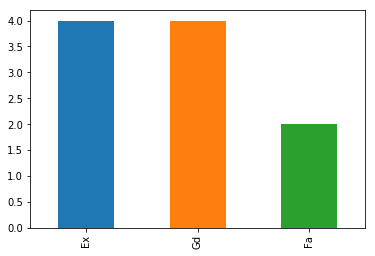

In [25]:
############ PoolQC ############
#Do not worry about, we are removing this feature later anyway.
combined_df.PoolQC.value_counts().plot(kind='bar')
combined_df.PoolQC.value_counts() #There are only 10 values that are not NaN. This is why we are removing this feature.
combined_df = combined_df.fillna({'PoolQC':'NA'})

In [26]:
########## Fence ##########
#combined_df.loc[combined_df.Fence.isnull(),:]

#We must replace this value with NA = No Fence.
combined_df = combined_df.fillna({'Fence':'NA'})

In [27]:
########## MiscFeature ##########
MF_NA1 = combined_df.loc[combined_df.MiscFeature.isnull(),:]
MF_NA = combined_df.loc[~combined_df.MiscFeature.isnull(),:] #This is to look at all non-null values


# problem_ind = []
# for i in MF_NA1.index:
#     if MF_NA1.loc[i,'MiscVal'] != 0:
#         problem_ind.append(i)
# problem_ind #=2546

combined_df.loc[2546,:]

unique_misc_val = MF_NA.MiscFeature.unique()
unique_misc_val

# for i in unique_misc_val:
#     curr_misc = i
#     mean_val = np.mean(MF_NA.loc[MF_NA.MiscFeature==curr_misc,'MiscVal'])
#     print(i,mean_val)
#Based on the above for loop it looks like the most likely candidate is Gar2.


#Prices of sheds
# MF_NA.loc[MF_NA.MiscFeature==unique_misc_val[0],{'MiscFeature','MiscVal'}]
# MF_NA.loc[MF_NA.MiscFeature==unique_misc_val[0],{'MiscVal'}].hist()

#Prices of Gar2
#MF_NA.loc[MF_NA.MiscFeature==unique_misc_val[1],{'MiscVal'}].hist()

#Prices of Othr
#MF_NA.loc[MF_NA.MiscFeature==unique_misc_val[2],{'MiscVal'}].hist()

#Prices of TenC
#MF_NA.loc[MF_NA.MiscFeature==unique_misc_val[3],{'MiscFeature','MiscVal'}] #only one value and its 2000
#MF_NA.loc[MF_NA.MiscFeature==unique_misc_val[3],{'MiscVal'}].hist()

combined_df.loc[2546,'MiscFeature'] = 'Gar2'
combined_df = combined_df.fillna({'MiscFeature':'NA'})

In [28]:
############## SaleType #############
combined_df.loc[combined_df.SaleType.isnull(),:]

#Check on SaleCondition to see if they are related or not.
ST_SC = pd.crosstab(combined_df.SaleType,combined_df.SaleCondition)
chi2_contingency(ST_SC,correction=False)
ST_SC

combined_df = combined_df.fillna({'SaleType':'WD'})

In [29]:
############CORRELATIONS##########
#RUN THIS AT ONE POINT TO SEE THE CORRELATIONS OF EVERYTHING BEFORE REMOVING THESE VALUES#

# #cwd = os.getcwd()
# save_directory = '/Users/armenta/Desktop/Data Science/Kaggle/Getting Started Projects/Housing Data'
# corr_vars = combined_df.corr()
# output1 = corr_vars.style.background_gradient(cmap='coolwarm')
# output1.to_excel(save_directory + '/correlations (combined_df, DP2, 10152019).xlsx',engine='openpyxl')
# # file = open('correlations (combined_df) 10152019.pdf','w+')
# # file.write(output1)
# # file.close()

# #Looking at SalePrice
# train_X3 = combined_df.loc[combined_df.Id <= train_IDs[len(train_IDs)-1],:]
# train_X3 = pd.concat([train_X3,train_y],axis=1)
# corr_vars3 = train_X3.corr()
# output2 = corr_vars3.style.background_gradient(cmap='coolwarm')
# output2.to_excel(save_directory + '/correlations (train_X3, DP2, 10152019).xlsx',engine='openpyxl')
# # file = open('correlations (train_X3) 10152019.pdf','w+')
# # file.write(output2)
# # file.close()

In [30]:
#Dropping the 9 useless columns preliminarily before we look at missing values.
#We will drop the ID variable just before we start training algorithms, as we need this variable
#to seperate the test and train data at the last minute.
##########DO NOT DO THIS YET, THESE OTHER COLUMNS CAN BE USED TO HELP US WITH THE MISSING VALUES ANALYSIS.

combined_df = combined_df.drop(['MSSubClass','Utilities','Neighborhood','Street','Condition2','RoofMatl','Heating','CentralAir','PoolQC'],axis=1)

In [31]:
############ SAVE THE VARIABLES WITH PICKLE ##############
pickle_list = [combined_df,train_y,train_IDs,test_IDs]
f = open('DataPipeline2_pt1.pckl','wb')
pickle.dump(pickle_list,f)
f.close()

# combined_df111 = pickle_list[0]
# train_y111 = pickle_list[1]
# train_IDs111 = pickle_list[2]
# test_IDs111 = pickle_list[3]

In [32]:
#Code that is not being used
#Exterior1st correlation plots
#For some reason none of these plots fully plots the correlations
#I know why!! it is only finding correlations for the numerical NOT Nominal variables.
##This way doesn't plot all of the correlations
# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(111)
# cax = ax.matshow(corr_vars,cmap='coolwarm', vmin=-1, vmax=1)
# fig.colorbar(cax)
# ticks = np.arange(0,len(combined_df.columns),1)
# ax.set_xticks(ticks)
# plt.xticks(rotation=90)
# ax.set_yticks(ticks)
# ax.set_xticklabels(combined_df.columns)
# ax.set_yticklabels(combined_df.columns)
# #plt.axis('scaled')
# #plt.savefig('correlations (Housing Prices 10072019)')
# plt.show()

# plt.figure(figsize=(30,30))
# plt.matshow(corr_vars,fignum=1)
# plt.xticks(range(len(combined_df.columns)), combined_df.columns)
# plt.yticks(range(len(combined_df.columns)), combined_df.columns)
# plt.colorbar()
# plt.axis('scaled')
# plt.show()


# f = plt.figure(figsize=(19, 15))
# plt.matshow(corr_vars, fignum=f.number)
# plt.xticks(range(combined_df.shape[1]), combined_df.columns, rotation=90)
# plt.yticks(range(combined_df.shape[1]), combined_df.columns)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)